In [102]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.transforms import Affine2D
from pytrends.request import TrendReq


df = yf.download("BTC-USD", start="2011-01-01", end="2025-05-27")

print(df.index.name)

print(df)



[*********************100%***********************]  1 of 1 completed

Date
Price               Close           High            Low           Open  \
Ticker            BTC-USD        BTC-USD        BTC-USD        BTC-USD   
Date                                                                     
2014-09-17     457.334015     468.174011     452.421997     465.864014   
2014-09-18     424.440002     456.859985     413.104004     456.859985   
2014-09-19     394.795990     427.834991     384.532013     424.102997   
2014-09-20     408.903992     423.295990     389.882996     394.673004   
2014-09-21     398.821014     412.425995     393.181000     408.084991   
...                   ...            ...            ...            ...   
2025-05-22  111673.281250  111970.171875  109285.070312  109673.492188   
2025-05-23  107287.796875  111798.906250  106841.304688  111679.359375   
2025-05-24  107791.156250  109454.523438  106895.289062  107278.507812   
2025-05-25  109035.390625  109313.304688  106683.375000  107802.273438   
2025-05-26  109440.367188  110376

In [103]:
# 1. Load price data
# must have 'Date' and 'Close' columns

df = df.reset_index()
print(df.columns)
df['Date'] = pd.to_datetime(df['Date'])
df['t'] = (df['Date'] - df['Date'].min()).dt.days  # time in days





MultiIndex([(  'Date',        ''),
            ( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])


Price  Date   Close    High     Low    Open  Volume   t
Ticker      BTC-USD BTC-USD BTC-USD BTC-USD BTC-USD    
0       NaT     NaN     NaN     NaN     NaN     NaN NaN
1       NaT     NaN     NaN     NaN     NaN     NaN NaN
2       NaT     NaN     NaN     NaN     NaN     NaN NaN
3       NaT     NaN     NaN     NaN     NaN     NaN NaN
4       NaT     NaN     NaN     NaN     NaN     NaN NaN
...     ...     ...     ...     ...     ...     ...  ..
3900    NaT     NaN     NaN     NaN     NaN     NaN NaN
3901    NaT     NaN     NaN     NaN     NaN     NaN NaN
3902    NaT     NaN     NaN     NaN     NaN     NaN NaN
3903    NaT     NaN     NaN     NaN     NaN     NaN NaN
3904    NaT     NaN     NaN     NaN     NaN     NaN NaN

[3905 rows x 7 columns]
Price  Date   Close    High     Low    Open  Volume   t
Ticker      BTC-USD BTC-USD BTC-USD BTC-USD BTC-USD    
0       NaT     NaN     NaN     NaN     NaN     NaN NaN
1       NaT     NaN     NaN     NaN     NaN     NaN NaN
2       NaT     NaN    

<Axes: >

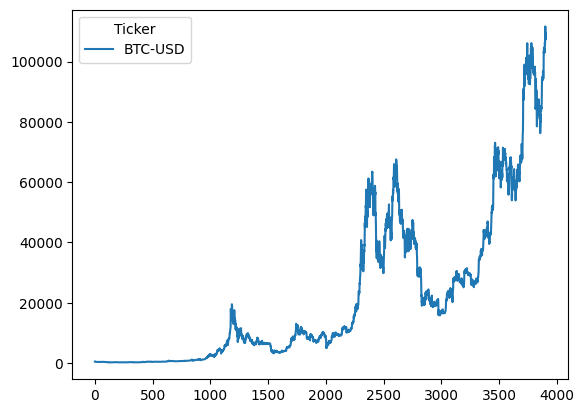

In [104]:
print(df[df['Close'] <= 0])
df = df.dropna(how='all')
print(df[df['Close'].isna()])
df['Close'].plot()





In [105]:
# 2. Log transform price

df['log_price'] = np.log(df['Close'])

print(df)

Price        Date          Close           High            Low           Open  \
Ticker                   BTC-USD        BTC-USD        BTC-USD        BTC-USD   
0      2014-09-17     457.334015     468.174011     452.421997     465.864014   
1      2014-09-18     424.440002     456.859985     413.104004     456.859985   
2      2014-09-19     394.795990     427.834991     384.532013     424.102997   
3      2014-09-20     408.903992     423.295990     389.882996     394.673004   
4      2014-09-21     398.821014     412.425995     393.181000     408.084991   
...           ...            ...            ...            ...            ...   
3900   2025-05-22  111673.281250  111970.171875  109285.070312  109673.492188   
3901   2025-05-23  107287.796875  111798.906250  106841.304688  111679.359375   
3902   2025-05-24  107791.156250  109454.523438  106895.289062  107278.507812   
3903   2025-05-25  109035.390625  109313.304688  106683.375000  107802.273438   
3904   2025-05-26  109440.36

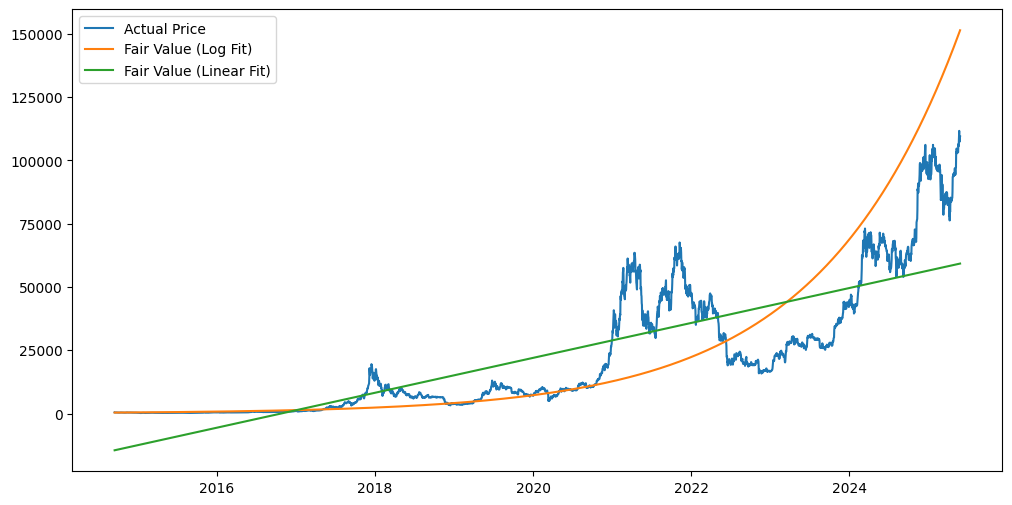

In [106]:

X = df[['t']]
y = df['log_price']
model = LinearRegression().fit(X, y)

df['log_fair_value'] = model.predict(X)
df['fair_value'] = np.exp(df['log_fair_value'])  # back to price scale

y = df['Close']

linear_model = LinearRegression()
linear_model.fit(X, y)
df['linear_fit'] = linear_model.predict(X)

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Actual Price')
plt.plot(df['Date'], df['fair_value'], label='Fair Value (Log Fit)')
plt.plot(df['Date'], df['linear_fit'], label='Fair Value (Linear Fit)')
plt.legend()
plt.show()

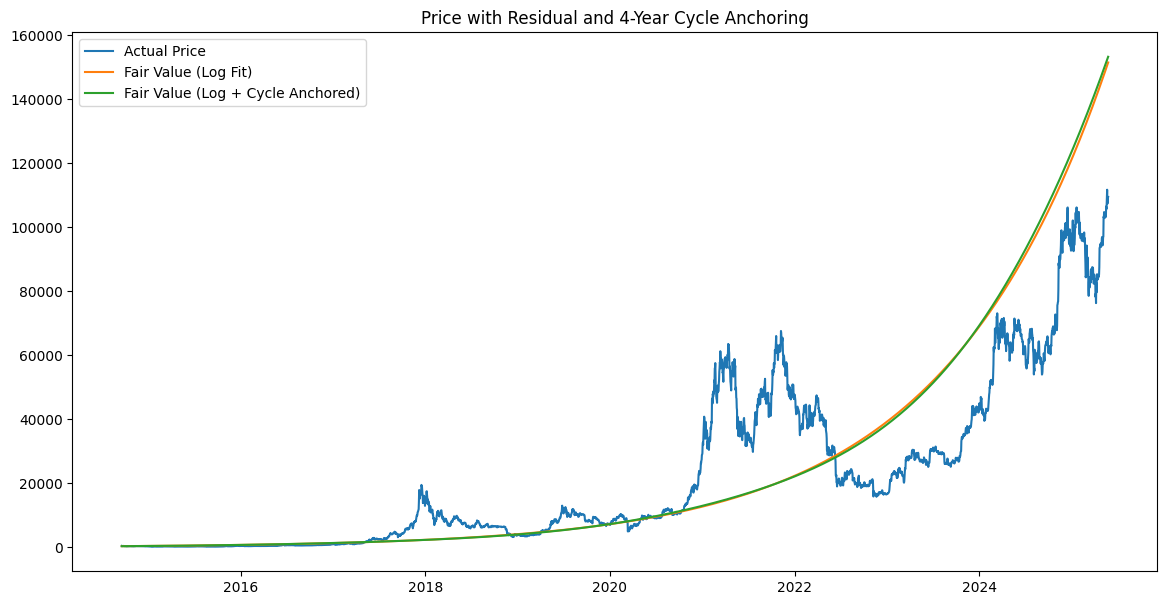

In [107]:
y_close = df['Close']
linear_model = LinearRegression().fit(X, y_close)
df['linear_fit'] = linear_model.predict(X)

df['residuals'] = df['log_price'] - df['log_fair_value']

window = 20
df['residuals_anchored'] = df['residuals'] - df['residuals'].rolling(window).mean()

cycle_period = 4 * 365  # 1460 days
df['cycle_sin'] = np.sin(2 * np.pi * df['t'] / cycle_period)
df['cycle_cos'] = np.cos(2 * np.pi * df['t'] / cycle_period)

X_cycle = df[['cycle_sin', 'cycle_cos']]
cycle_model = LinearRegression().fit(X_cycle, df['residuals_anchored'].fillna(0))
df['cycle_fit'] = cycle_model.predict(X_cycle)

df['log_fair_value_adjusted'] = df['log_fair_value'] + df['cycle_fit']
df['fair_value_adjusted'] = np.exp(df['log_fair_value_adjusted'])

plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Close'], label='Actual Price')
plt.plot(df['Date'], df['fair_value'], label='Fair Value (Log Fit)')
plt.plot(df['Date'], df['fair_value_adjusted'], label='Fair Value (Log + Cycle Anchored)')
plt.legend()
plt.title('Price with Residual and 4-Year Cycle Anchoring')
plt.show()

In [108]:
Altcoin_Index = yf.download(["ETH-USD", "SOL-USD", "ADA-USD", "XRP-USD", "LINK-USD", "BNB-USD",], start="2011-01-01", end="2025-05-27",)['Close']
Memecoin_Index = yf.download(["DOGE-USD", "SHIB-USD", "PEPE24478-USD", "BONK-USD",], start="2011-01-01", end="2025-05-27",)['Close']

[*********************100%***********************]  6 of 6 completed
[*********************100%***********************]  4 of 4 completed


In [109]:
print(Altcoin_Index)
print(Memecoin_Index)

Ticker       ADA-USD     BNB-USD      ETH-USD   LINK-USD     SOL-USD   XRP-USD
Date                                                                          
2017-11-09  0.032053    1.990770   320.884003   0.223969         NaN  0.217488
2017-11-10  0.027119    1.796840   299.252991   0.187602         NaN  0.206483
2017-11-11  0.027437    1.670470   314.681000   0.179770         NaN  0.210430
2017-11-12  0.023977    1.519690   307.907990   0.170898         NaN  0.197339
2017-11-13  0.025808    1.686620   316.716003   0.183071         NaN  0.203442
...              ...         ...          ...        ...         ...       ...
2025-05-22  0.808138  686.235657  2664.156982  16.736061  179.690948  2.429795
2025-05-23  0.746380  656.231689  2526.441895  15.521186  173.825424  2.294321
2025-05-24  0.747192  668.306519  2530.646240  15.355583  176.042404  2.332870
2025-05-25  0.759983  669.916870  2551.763916  15.526290  175.725479  2.342975
2025-05-26  0.759555  674.392639  2564.138428  15.52

In [110]:
Altcoin_Index['Index_Average'] = Altcoin_Index.mean(axis=1)
Memecoin_Index['Index_Average'] = Memecoin_Index.mean(axis=1)

In [111]:
print(Altcoin_Index.tail())
print(Memecoin_Index.tail())
df.tail

Ticker       ADA-USD     BNB-USD      ETH-USD   LINK-USD     SOL-USD  \
Date                                                                   
2025-05-22  0.808138  686.235657  2664.156982  16.736061  179.690948   
2025-05-23  0.746380  656.231689  2526.441895  15.521186  173.825424   
2025-05-24  0.747192  668.306519  2530.646240  15.355583  176.042404   
2025-05-25  0.759983  669.916870  2551.763916  15.526290  175.725479   
2025-05-26  0.759555  674.392639  2564.138428  15.527998  174.907898   

Ticker       XRP-USD  Index_Average  
Date                                 
2025-05-22  2.429795     591.676264  
2025-05-23  2.294321     562.510149  
2025-05-24  2.332870     565.571801  
2025-05-25  2.342975     569.339252  
2025-05-26  2.310661     572.006196  
Ticker      BONK-USD  DOGE-USD  PEPE24478-USD  SHIB-USD  Index_Average
Date                                                                  
2025-05-22  0.000023  0.245028       0.000015  0.000015       0.061270
2025-05-23  0.00

<bound method NDFrame.tail of Price        Date          Close           High            Low           Open  \
Ticker                   BTC-USD        BTC-USD        BTC-USD        BTC-USD   
0      2014-09-17     457.334015     468.174011     452.421997     465.864014   
1      2014-09-18     424.440002     456.859985     413.104004     456.859985   
2      2014-09-19     394.795990     427.834991     384.532013     424.102997   
3      2014-09-20     408.903992     423.295990     389.882996     394.673004   
4      2014-09-21     398.821014     412.425995     393.181000     408.084991   
...           ...            ...            ...            ...            ...   
3900   2025-05-22  111673.281250  111970.171875  109285.070312  109673.492188   
3901   2025-05-23  107287.796875  111798.906250  106841.304688  111679.359375   
3902   2025-05-24  107791.156250  109454.523438  106895.289062  107278.507812   
3903   2025-05-25  109035.390625  109313.304688  106683.375000  107802.273438  

In [112]:
Altcoin_Index = Altcoin_Index.reset_index()
print(Altcoin_Index.columns)
Altcoin_Index.head

Memecoin_Index = Memecoin_Index.reset_index()
print(Memecoin_Index.columns)
Memecoin_Index.head


Index(['Date', 'ADA-USD', 'BNB-USD', 'ETH-USD', 'LINK-USD', 'SOL-USD',
       'XRP-USD', 'Index_Average'],
      dtype='object', name='Ticker')
Index(['Date', 'BONK-USD', 'DOGE-USD', 'PEPE24478-USD', 'SHIB-USD',
       'Index_Average'],
      dtype='object', name='Ticker')


<bound method NDFrame.head of Ticker       Date  BONK-USD  DOGE-USD  PEPE24478-USD  SHIB-USD  Index_Average
0      2017-11-09       NaN  0.001415            NaN       NaN       0.001415
1      2017-11-10       NaN  0.001163            NaN       NaN       0.001163
2      2017-11-11       NaN  0.001201            NaN       NaN       0.001201
3      2017-11-12       NaN  0.001038            NaN       NaN       0.001038
4      2017-11-13       NaN  0.001211            NaN       NaN       0.001211
...           ...       ...       ...            ...       ...            ...
2751   2025-05-22  0.000023  0.245028       0.000015  0.000015       0.061270
2752   2025-05-23  0.000021  0.224814       0.000014  0.000014       0.056216
2753   2025-05-24  0.000021  0.225297       0.000014  0.000014       0.056337
2754   2025-05-25  0.000021  0.224984       0.000014  0.000014       0.056258
2755   2025-05-26  0.000020  0.226025       0.000014  0.000014       0.056518

[2756 rows x 6 columns]>

<bound method NDFrame.head of Ticker       Date   ADA-USD     BNB-USD      ETH-USD   LINK-USD     SOL-USD  \
0      2017-11-09  0.032053    1.990770   320.884003   0.223969         NaN   
1      2017-11-10  0.027119    1.796840   299.252991   0.187602         NaN   
2      2017-11-11  0.027437    1.670470   314.681000   0.179770         NaN   
3      2017-11-12  0.023977    1.519690   307.907990   0.170898         NaN   
4      2017-11-13  0.025808    1.686620   316.716003   0.183071         NaN   
...           ...       ...         ...          ...        ...         ...   
2751   2025-05-22  0.808138  686.235657  2664.156982  16.736061  179.690948   
2752   2025-05-23  0.746380  656.231689  2526.441895  15.521186  173.825424   
2753   2025-05-24  0.747192  668.306519  2530.646240  15.355583  176.042404   
2754   2025-05-25  0.759983  669.916870  2551.763916  15.526290  175.725479   
2755   2025-05-26  0.759555  674.392639  2564.138428  15.527998  174.907898   

Ticker   XRP-USD  Ind

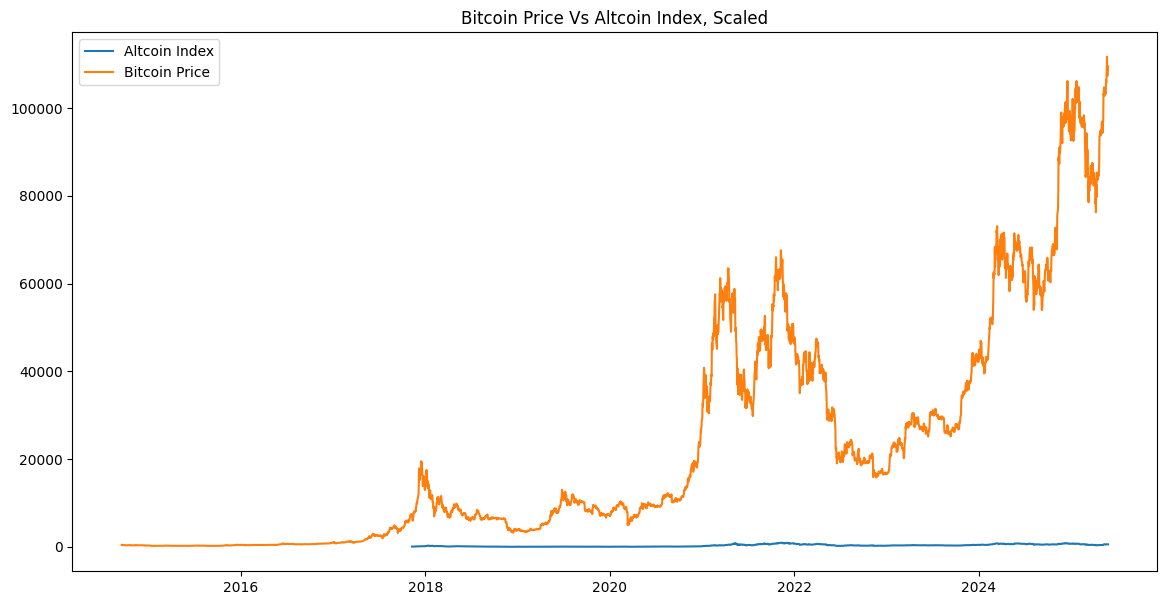

In [113]:
print(Altcoin_Index.head)
print(df.head)

plt.figure(figsize=(14, 7))
plt.plot(Altcoin_Index['Date'], Altcoin_Index['Index_Average'], label='Altcoin Index')
plt.plot(df['Date'], df['Close'], label='Bitcoin Price')
plt.legend()
plt.title('Bitcoin Price Vs Altcoin Index, Scaled')
plt.show()

In [114]:
Altcoin_Index['Average Scaled'] = (Altcoin_Index['Index_Average'] - Altcoin_Index['Index_Average'].min()) / (Altcoin_Index['Index_Average'].max() - Altcoin_Index['Index_Average'].min())
df['Bitcoin Price Scaled'] = (df['Close'] - df['Close'].min()) / (df['Close'].max() - df['Close'].min())
Memecoin_Index['Average Scaled'] = (Memecoin_Index['Index_Average'] - Memecoin_Index['Index_Average'].min()) / (Memecoin_Index['Index_Average'].max() - Memecoin_Index['Index_Average'].min())
df['fair_value_scaled'] = (df['fair_value'] - df['fair_value'].min()) / (df['fair_value'].max() - df['fair_value'].min())
df['linear_fit_scaled'] = (df['linear_fit'] - df['linear_fit'].min()) / (df['linear_fit'].max() - df['linear_fit'].min())


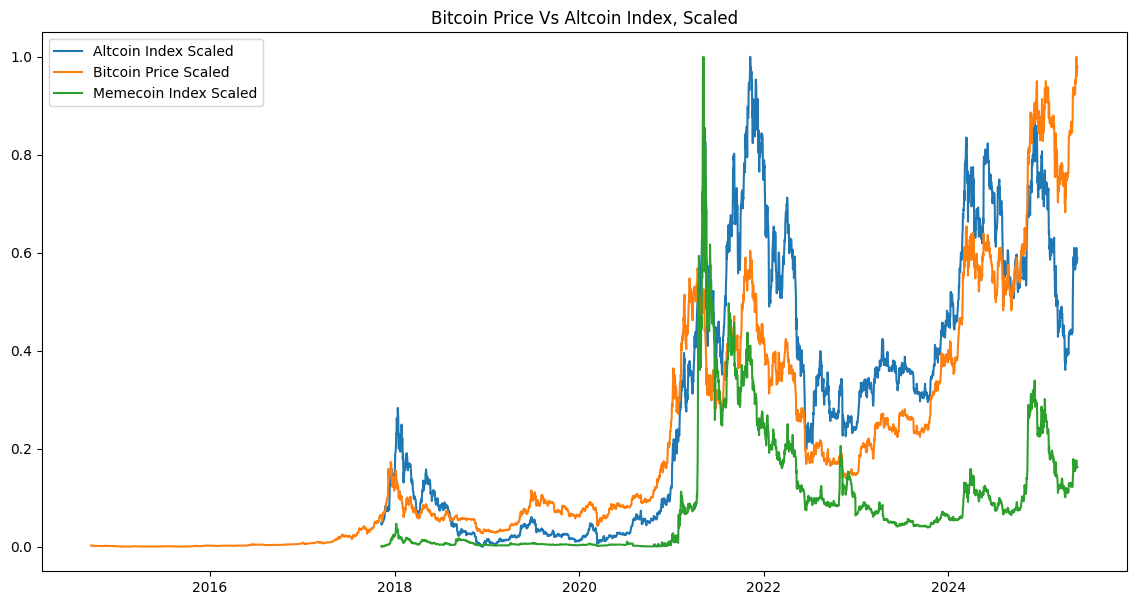

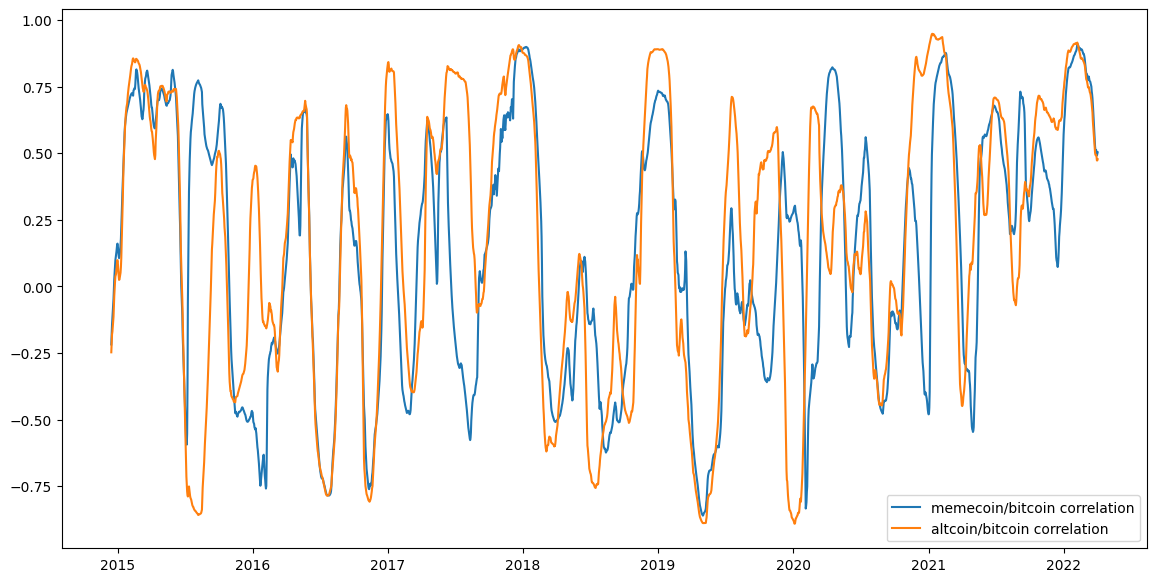

In [117]:
plt.figure(figsize=(14, 7))
plt.plot(Altcoin_Index['Date'], Altcoin_Index['Average Scaled'], label='Altcoin Index Scaled')
plt.plot(df['Date'], df['Bitcoin Price Scaled'], label='Bitcoin Price Scaled')
plt.plot(Memecoin_Index['Date'], Memecoin_Index['Average Scaled'], label='Memecoin Index Scaled')


plt.legend()
plt.title('Bitcoin Price Vs Altcoin Index, Scaled')
plt.show()

df['corr_alt'] = df['Bitcoin Price Scaled'].rolling(90).corr(Altcoin_Index['Average Scaled'])
df['corr_meme'] = df['Bitcoin Price Scaled'].rolling(90).corr(Memecoin_Index['Average Scaled'])
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['corr_meme'], label ='memecoin/bitcoin correlation')
plt.plot(df['Date'], df['corr_alt'], label ='altcoin/bitcoin correlation')
plt.legend()

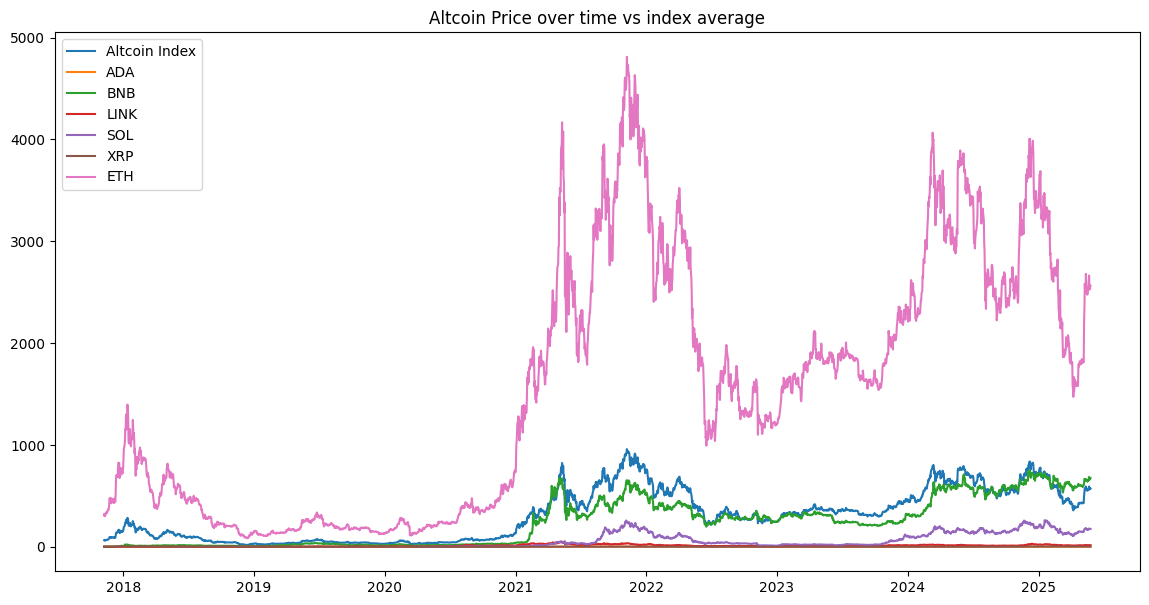

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(Altcoin_Index['Date'], Altcoin_Index['Index_Average'], label='Altcoin Index')
plt.plot(Altcoin_Index['Date'], Altcoin_Index['ADA-USD'], label='ADA')
plt.plot(Altcoin_Index['Date'], Altcoin_Index['BNB-USD'], label='BNB')
plt.plot(Altcoin_Index['Date'], Altcoin_Index['LINK-USD'], label='LINK')
plt.plot(Altcoin_Index['Date'], Altcoin_Index['SOL-USD'], label='SOL')               
plt.plot(Altcoin_Index['Date'], Altcoin_Index['XRP-USD'], label='XRP')
plt.plot(Altcoin_Index['Date'], Altcoin_Index['ETH-USD'], label='ETH')

plt.legend()
plt.title('Altcoin Price over time vs index average')
plt.show()